In [1]:
#!pip install onc

Here is the issue I raised about the odd pulse length from the PVIP AZFP.
https://github.com/OSOceanAcoustics/echopype/issues/1505

I edited the SV_OFFSET_LF dictionary in the echopype > convert > parse_azfp.py file. I arbitrarily added the offset 0.9 for a pulse of 800. (800: 0.9)

https://github.com/OSOceanAcoustics/echopype/blob/main/echopype/convert/parse_azfp.py#L24

## Download AZFP Data

In [2]:
from datetime import datetime
from netrc import netrc

from onc import ONC

# I store my ONC token in the password portion of a .netrc entry, but you can replace it with anything here.
_, __ , ONC_TOKEN = netrc().authenticators(host = 'data.oceannetworks.ca')

onc = ONC(token = ONC_TOKEN)

BDT = datetime(2025, 5, 15, 1 ,0, 0).strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z'  # Request begin datetime.
EDT = datetime(2025, 5, 15, 1, 59, 59, 999999).strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z' # Request end datetime.

req_dp_params = {
    'token': ONC_TOKEN,
    'locationCode': 'PVIP',
    'deviceCategoryCode': 'ECHOSOUNDERBIOA',
    'dataProductCode': 'AAPTS', 
    'extension': '01a',
    'dateFrom': BDT,
    'dateTo': EDT,
    'dpo_aslBinarySource': 0
}

dpreq = onc.requestDataProduct(filters = req_dp_params)
dpstatus = onc.checkDataProduct(dpreq['dpRequestId'])
dprun = onc.runDataProduct(dpreq['dpRequestId'])
download = onc.downloadDataProduct(dprun['runIds'][0], overwrite = True)

Request Id: 25063229
Estimated File Size: 43 MB
Estimated Processing Time: 5 min
To cancel the running data product, run 'onc.cancelDataProduct(25063229)'

   queued
   data product running.
   3 files generated for this data product
   complete


   Search complete, waiting on the file system to synchronize (ASLAZFP55167_20250515T010000.235Z_20250515T015958.172Z.01a)......

## Pass Through Echopype

In [3]:
import echopype as ep
import numpy as np
import matplotlib.pyplot as plt

raw_path = 'output/ASLAZFP55167_20250515T010000.235Z_20250515T015958.172Z.01a'
xml_path = 'output/ASLAZFP55167_20250515T010000.235_20250515T015958.172Z.xml'

ed = ep.open_raw(raw_path, sonar_model='AZFP', xml_path = xml_path)
#ed = ep.combine_echodata([ed])  # Looks like it handles single element lists just fine.

In [4]:
# Using the calibrate module with the AZFP requires ancillary parameters. Presumably to calculate sound velocity? Unsure if the inputs can be arrays.
dummy_env_vars = {'temperature': 12.345,'salinity': 34.567, 'pressure': 54.321} 

sv = ep.calibrate.compute_Sv(ed, env_params = dummy_env_vars)

# This is the same value from the glider AZFP echopype example.https://github.com/OSOceanAcoustics/echopype-examples/blob/main/notebooks/glider_AZFP.ipynb
rbsv = ep.clean.remove_background_noise(
    sv, ping_num=5,
    range_sample_num=5,
    SNR_threshold="2.0dB",  
)

Text(0.5, 0.98, 'ONC PVIP-ECHOSOUNDERBIOA')

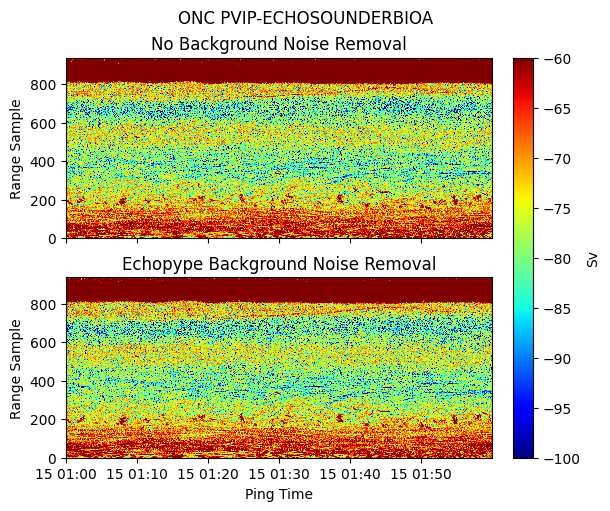

In [5]:

fig, ax = plt.subplots(2,1, figsize = (6,5), constrained_layout = True, sharex = True, sharey = True)

ax[0].set_title('No Background Noise Removal')
sv38 = sv.sel(channel = '55167-38-1')
y,x = np.meshgrid(sv38.range_sample,sv38.ping_time)
z = sv38.Sv
pmesh = ax[0].pcolormesh(x,y, z, cmap = 'jet',vmin = -100, vmax = -60)


ax[1].set_title('Echopype Background Noise Removal')
sv38 = rbsv.sel(channel = '55167-38-1')
y,x = np.meshgrid(sv38.range_sample,sv38.ping_time)
z = sv38.Sv
pmesh = ax[1].pcolormesh(x,y, z, cmap = 'jet',vmin = -100, vmax = -60)
fig.colorbar(pmesh, ax = [ax[0],ax[1]], label ='Sv')

ax[-1].set_xlabel('Ping Time')
ax[0].set_ylabel('Range Sample')
ax[1].set_ylabel('Range Sample')
fig.suptitle('ONC PVIP-ECHOSOUNDERBIOA')